# Conditioning and Stability
## February 8th, 2022
### Overview: Calculating, dealing with condtion numbers of matrices, stability of functions

In [1]:
import numpy as np
import sympy as sy
from scipy import linalg as la
from matplotlib import pyplot as plt

In [2]:
# Problem 1
def matrix_cond(A):
    """Calculate the condition number of A with respect to the 2-norm."""
    #getting the singular values
    sigma = la.svdvals(A)
    
    #if the smallest singular value is 0, return infinity
    if min(sigma) == 0:
        return np.inf
    
    #else calculate 
    else: 
        return max(sigma)/min(sigma)

In [3]:
# Problem 2
def prob2():
    """Randomly perturb the coefficients of the Wilkinson polynomial by
    replacing each coefficient c_i with c_i*r_i, where r_i is drawn from a
    normal distribution centered at 1 with standard deviation 1e-10.
    Plot the roots of 100 such experiments in a single figure, along with the
    roots of the unperturbed polynomial w(x).

    Returns:
        (float) The average absolute condition number.
        (float) The average relative condition number.
    """
    Ks = []
    ks = []
    w_roots = np.arange(1, 21)

    # Get the exact Wilkinson polynomial coefficients using SymPy.
    x, i = sy.symbols('x i')
    w = sy.poly_from_expr(sy.product(x-i, (i, 1, 20)))[0]
    w_coeffs = np.array(w.all_coeffs())
    
    for _ in range(100):
        #draw from normal distribution
        r = np.random.normal(loc=1.0,scale=1e-10,size=21)
        #perturb coeffs
        new_coeffs = w_coeffs*r
        #get new roots, sort both new and og
        new_roots = np.roots(np.poly1d(new_coeffs))
        w_roots = np.sort(w_roots)
        new_roots = np.sort(new_roots)
        
        #plot (only want to do legend once)
        if _ == 0:
            plt.scatter(np.real(w_roots),np.imag(w_roots),label='original')
            plt.scatter(np.real(new_roots),np.imag(new_roots),marker='.',s=10,label='perturbed')
            plt.legend()
        else:
            plt.scatter(np.real(new_roots),np.imag(new_roots),marker='.',s=10)
        #labeling
        plt.xlabel('Real Axis')
        plt.ylabel('Imaginary Axis')
                   
        #getting condition numbers (abs then rel)
        K = la.norm(new_roots - w_roots, np.inf) / la.norm(r, np.inf)
        Ks.append(K)
        k = K * la.norm(w_coeffs, np.inf) / la.norm(w_roots, np.inf)
        ks.append(k)
                   
    return np.mean(Ks),np.mean(ks)

(4.83206974109482, 3.33503649094549e+18)

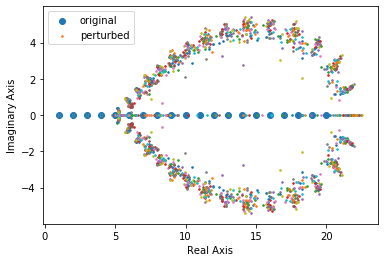

In [4]:
prob2()

In [5]:
# Helper function
def reorder_eigvals(orig_eigvals, pert_eigvals):
    """Reorder the perturbed eigenvalues to be as close to the original eigenvalues as possible.
    
    Parameters:
        orig_eigvals ((n,) ndarray) - The eigenvalues of the unperturbed matrix A
        pert_eigvals ((n,) ndarray) - The eigenvalues of the perturbed matrix A+H
        
    Returns:
        ((n,) ndarray) - the reordered eigenvalues of the perturbed matrix
    """
    n = len(pert_eigvals)
    sort_order = np.zeros(n).astype(int)
    dists = np.abs(orig_eigvals - pert_eigvals.reshape(-1,1))
    for _ in range(n):
        index = np.unravel_index(np.argmin(dists), dists.shape)
        sort_order[index[0]] = index[1]
        dists[index[0],:] = np.inf
        dists[:,index[1]] = np.inf
    return pert_eigvals[sort_order]

# Problem 3
def eig_cond(A):
    """Approximate the condition numbers of the eigenvalue problem at A.

    Parameters:
        A ((n,n) ndarray): A square matrix.

    Returns:
        (float) The absolute condition number of the eigenvalue problem at A.
        (float) The relative condition number of the eigenvalue problem at A.
    """
    #making H
    reals = np.random.normal(0, 1e-10, A.shape)
    imags = np.random.normal(0, 1e-10, A.shape)
    H = reals + 1j*imags
    
    #getting eigenvalues
    eigs1 = la.eigvals(A)
    eigs2 = la.eigvals(A+H)
    eigs2 = reorder_eigvals(eigs1,eigs2)
    
    #calculating condition numbers
    K = la.norm(eigs1 - eigs2,ord=2) / la.norm(H,ord=2)
    k = K * la.norm(A,ord=2)/la.norm(eigs1,ord=2)
    
    return K,k

In [6]:
# Problem 4
def prob4(domain=[-100, 100, -100, 100], res=50):
    """Create a grid [x_min, x_max] x [y_min, y_max] with the given resolution. For each
    entry (x,y) in the grid, find the relative condition number of the
    eigenvalue problem, using the matrix   [[1, x], [y, 1]]  as the input.
    Use plt.pcolormesh() to plot the condition number over the entire grid.

    Parameters:
        domain ([x_min, x_max, y_min, y_max]):
        res (int): number of points along each edge of the grid.
    """
    x_vals = np.linspace(domain[0], domain[1], res)
    y_vals = np.linspace(domain[2], domain[3], res)
    X_Vals, Y_Vals = np.meshgrid(x_vals, y_vals)
    K = np.empty((res,res))
    
    #for each point in the grid
    for i,x in enumerate(x_vals):
        for j,y in enumerate(y_vals):
            
            #make the matrix and fill K with the condition number
            A = np.array([[1,x],[y,1]])#K[i,j] = 1
            K[i,j] = eig_cond(A)[1]
    
    #plotting
    plt.pcolormesh(x_vals,y_vals,K,cmap='gray_r')
    plt.colorbar()

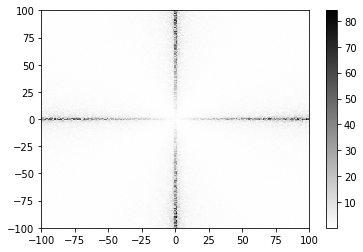

In [7]:
prob4(res=200)

In [14]:
# Problem 5
def prob5(n):
    """Approximate the data from "stability_data.npy" on the interval [0,1]
    with a least squares polynomial of degree n. Solve the least squares
    problem using the normal equation and the QR decomposition, then compare
    the two solutions by plotting them together with the data. Return
    the mean squared error of both solutions, ||Ax-b||_2.

    Parameters:
        n (int): The degree of the polynomial to be used in the approximation.

    Returns:
        (float): The forward error using the normal equations.
        (float): The forward error using the QR decomposition.
    """
    #loading data
    xk, yk = np.load("stability_data.npy").T
    A = np.vander(xk, n+1)

    #first way of solving - la.inv
    c1 = la.inv(A.T@A) @ A.T @ yk
    
    #second way - la.qr have Rc = Q.Ty
    Q,R = la.qr(A,mode='economic')[:2]
    c2 = la.solve_triangular(R,Q.T@yk)
    
    #plotting
    p1 = np.polyval(c1,xk)
    p2 = np.polyval(c2,xk)
    plt.plot(xk,p1,'r',label='Inverse Method')
    plt.plot(xk,p2,'b',label='QR Method')
    plt.scatter(xk,yk,color='r',marker='.',label='data')
    plt.title('polynomial approximations of data')
    plt.legend()
    
    #returning forward error for inverse and QR methods, respectively
    return la.norm(A@c1 - yk,ord=2), la.norm(A@c2 - yk,ord=2)

(5.564833717240033, 4.568370944943427)

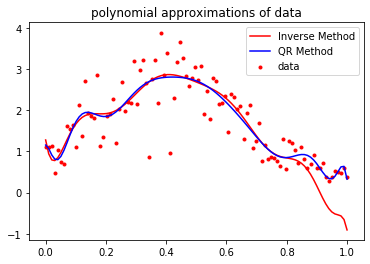

In [15]:
prob5(14)

In [10]:
# Problem 6
def prob6():
    """For n = 5, 10, ..., 50, compute the integral I(n) using SymPy (the
    true values) and the subfactorial formula (may or may not be correct).
    Plot the relative forward error of the subfactorial formula for each
    value of n. Use a log scale for the y-axis.
    """
    #defining symbols
    n,k,x = sy.symbols('n k x')
    
    #making expressions - the first to integrate, the second to just sub into
    i1 = x**n * sy.exp(x - 1)
    I2 = ((-1)**n)*(sy.subfactorial(n) -  sy.factorial(n) / np.e)
    
    #initializing list to hold values
    I1s = []
    I2s = []
    
    #for each N
    Ns = np.arange(5,55,5)
    for N in Ns:
        #sub in N, calculate integral, append
        itemp = i1.subs({n:int(N)})
        I1 = float(sy.integrate( itemp ,(x,0,1)))
        I1s.append(I1)
        
        #sub in N, append
        I2temp = float(I2.subs({n:int(N)}))
        I2s.append(I2temp)
    
    #finding forward difference error
    errs = []
    for i in range(len(Ns)):
        err = abs(I1s[i]  -  I2s[i])/abs(I1s[i])
        errs.append(err)
    
    #plotting on loglog
    plt.plot(Ns,errs,'green')
    plt.yscale('log')
    plt.xlabel('n')
    plt.xticks(ticks=Ns,labels=Ns)
    plt.ylabel('forward difference error')
    plt.title('Plotting Error vs n value')

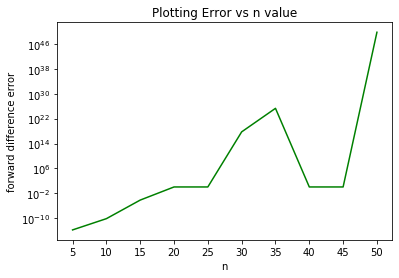

In [11]:
prob6()